In [ ]:
# import pandas as pd
# import numpy as np
# import re
#Importing everything from NLP Week 1 - following that as a guide for now
import gzip
import json
import matplotlib.pyplot as plt
import numpy as np
import re
import random
import pandas as pd
import seaborn as sns
from collections import Counter, defaultdict
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
pd.options.display.max_rows = 100
pd.options.display.width = 150
RANDOM_SEED = 696


: 

In [2]:
pd.get_option("display.width")

150

In [3]:
WikiLarge_Train_df = pd.read_csv(r'/Users/staceybruestle/Documents/Documents/Education/MADS/Coursework/aSIADS696- Milestone 2/Readability Project/Data/WikiLarge_Train.csv')#, \

In [4]:
# print(WikiLarge_Train_df.tail())
# print(WikiLarge_Train_df['label'].value_counts())

In [5]:
WikiLarge_Train_df['parsed_list'] = 0
WikiLarge_Train_df['All_Characters'] = 0
WikiLarge_Train_df['Is_Int'] = 0
for i, row in WikiLarge_Train_df.iterrows():
        temp = row['original_text']
        WikiLarge_Train_df['parsed_list'].at[i] = re.split(r'(\s)', temp)
        if temp.isalpha():
                WikiLarge_Train_df['All_Characters'].at[i] = 1
        try:
                int(temp)
                WikiLarge_Train_df['Is_Int'].at[i] = 1
        except:
                pass

        #WikiLarge_Train_df['parsed_list'].at[i] = re.split(r'(-|,|\s)\s*', temp)
        # Do we need to be greedy?

# Are commas always split by spaces?

In [6]:
print(WikiLarge_Train_df.head(5))

                                       original_text  label                                        parsed_list  All_Characters  Is_Int
0  There is manuscript evidence that Austen conti...      1  [There,  , is,  , manuscript,  , evidence,  , ...               0       0
1  In a remarkable comparative analysis , Mandaea...      1  [In,  , a,  , remarkable,  , comparative,  , a...               0       0
2  Before Persephone was released to Hermes , who...      1  [Before,  , Persephone,  , was,  , released,  ...               0       0
3  Cogeneration plants are commonly found in dist...      1  [Cogeneration,  , plants,  , are,  , commonly,...               0       0
4  Geneva -LRB- , ; , ; , ; ; -RRB- is the second...      1  [Geneva,  , -LRB-,  , ,,  , ;,  , ,,  , ;,  , ...               0       0


In [7]:
WikiLarge_Train_df['All_Characters'].value_counts()

0    407992
1      8776
Name: All_Characters, dtype: int64

In [8]:
#Not many -so I'm not going to worry about these
print(WikiLarge_Train_df['Is_Int'].value_counts())
print(WikiLarge_Train_df[WikiLarge_Train_df['Is_Int'] ==1 ]['label'].value_counts())
# The following shows there's no rhyme or reason to the way they're flagged
# WikiLarge_Train_df[WikiLarge_Train_df['Is_Int'] ==1 ].head(50)

0    416718
1        50
Name: Is_Int, dtype: int64
0    40
1    10
Name: label, dtype: int64


Okay, lets divide the set into train dev and test just for fun and see about getting started

In [9]:
train_df, dev_df, test_df = np.split(WikiLarge_Train_df.sample(frac=1, random_state= RANDOM_SEED), 
                       [int(.8*len(WikiLarge_Train_df)), int(.9*len(WikiLarge_Train_df))], axis = 0)

In [10]:
print(train_df.shape)
print(dev_df.shape)
print(test_df.shape)

(333414, 5)
(41677, 5)
(41677, 5)


FROM NLP Week 1:

What tokens should count as a "word" and how do we find them? For this exercise, we'll try extract three kinds of tokens using different methods to see what happens

1. ws_tokens: dict count of tokens separated by whitespace
2. alpha_ws_tokens: dict count of tokens separated by whitespace and are alpha numeric
3. alpha_re_tokens: dict count of tokens separated by word boundaries that only consist of alphanumeric characters

As quick example of how these are different, let's say we have the sentence "My computer says 'I don't know...' but after thinking about it, I think it does."

* The first case should return ['My', 'computer', 'says', "'I", "don't", "know...'", 'but', 'after', 'thinking', 'about', 'it,', 'I', 'think', 'it', 'does.'], which we can see contains a bunch of tokens that have punctuation with them.

* The second case should return ['My', 'computer', 'says', 'but', 'after', 'thinking', 'about', 'I', 'think', 'it'] which is filtering out a lot more tokens. We see that any token with any punctuation gets removed. This is probably too much but the tokens do look cleaner

* The third case should return ['My', 'computer', 'says', 'I', 'don', 't', 'know', 'but', 'after', 'thinking', 'about', 'it', 'I', 'think', 'it', 'does'], which gives us all the tokens. Here we see that it's also split "don't" into two tokens too! We could modify our regex some to allow intra-token punctuation to avoid this but for now we'll keep it a it simple.

In [11]:
ws_tokens = Counter()
alpha_ws_tokens = Counter()
alpha_re_tokens = Counter()
count = 0

for sent in tqdm(train_df.original_text):
#if count > 1:
    alphanumeric_list = []
    alpha_re_list = []
    sentlist = sent.split()

    ws_tokens.update(sentlist)

    for element in sentlist:
        #alphanumeric_regex = re.compile(r'[a-zA-Z0-9]+')
        alphanumeric_regex = re.compile(r'\w+')
        if re.fullmatch(alphanumeric_regex, element) != None:
            alphanumeric_list.append(element)
            #print("element:", element, "\nalpha_ws_list:",alpha_ws_list)

    alpha_re_list = re.findall(alphanumeric_regex, sent)
    alpha_ws_tokens.update(alphanumeric_list)
    alpha_re_tokens.update(alpha_re_list)

100%|██████████| 333414/333414 [00:08<00:00, 38699.08it/s]


In [12]:
print(len(ws_tokens))
print(len(alpha_ws_tokens))
print(len(alpha_re_tokens))

180497
150320
155812


In [13]:
top_50 = alpha_re_tokens.most_common(50)
#hidden tests are within this cell
top_50

[('the', 388051),
 ('of', 231298),
 ('in', 184434),
 ('and', 168008),
 ('a', 146692),
 ('is', 130853),
 ('to', 99037),
 ('RRB', 87115),
 ('LRB', 86878),
 ('The', 69017),
 ('was', 65924),
 ('as', 47474),
 ('for', 42317),
 ('by', 42126),
 ('on', 40038),
 ('with', 33040),
 ('s', 30582),
 ('that', 29589),
 ('from', 29501),
 ('are', 27668),
 ('an', 27376),
 ('or', 26066),
 ('It', 23917),
 ('at', 22762),
 ('his', 19793),
 ('which', 18768),
 ('In', 18721),
 ('it', 17895),
 ('also', 16284),
 ('has', 15611),
 ('be', 15144),
 ('he', 14975),
 ('born', 14891),
 ('first', 14506),
 ('were', 13468),
 ('France', 13454),
 ('He', 13349),
 ('one', 12754),
 ('known', 11524),
 ('who', 11262),
 ('United', 11159),
 ('not', 10888),
 ('its', 10738),
 ('department', 10574),
 ('have', 10282),
 ('city', 10253),
 ('A', 10196),
 ('de', 10067),
 ('1', 9896),
 ('commune', 9647)]

155812 0 155811
155812 0.05914372062349407 1.5241223608106686e-07


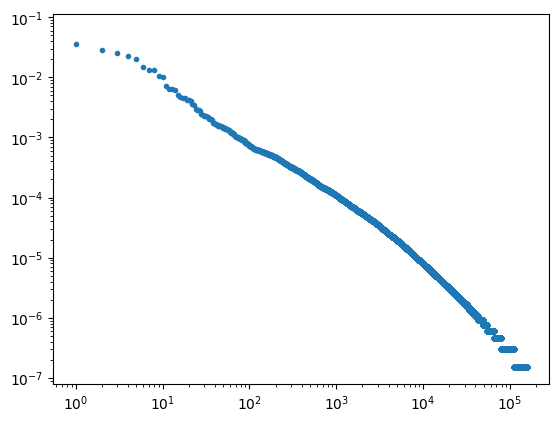

In [14]:
#Plot the word distribution
dict_pairs = dict(alpha_re_tokens)
total_counts = sum(dict_pairs.values())

#sorted_dict = {}
sorted_keys = sorted(dict_pairs, key=dict_pairs.get, reverse=True) 
x = [] #rank
y = [] #probability
count = 0
for w in sorted_keys:
    #print(w, dict_pairs[w], sorted_dict)
    x.append(count)
    y.append(dict_pairs[w] / total_counts)
    count += 1

print(len(x), x[0], x[-1])
print(len(y), y[0], y[-1])

ax = plt.plot(x, y, '.')
plt.yscale('log')
plt.xscale('log')

Convert text to features

In [15]:
vectorizer = TfidfVectorizer(min_df=500, stop_words= 'english')
X_train = vectorizer.fit_transform(train_df.original_text)
print(X_train.shape)

(333414, 1099)


In [16]:
#Make list of labels
y_train = list(train_df.label)

Fit the classifier - using all the data but could narrow this down to save time. Lets just see if it takes a long time

In [17]:
clf = LogisticRegression(random_state=RANDOM_SEED, max_iter=500, multi_class='ovr', solver= 'newton-cholesky')
#clf.fit(X_train[0:10000,:], y_train[0:10000])
clf.fit(X_train, y_train)

LogisticRegression(max_iter=500, multi_class='ovr', random_state=696,
                   solver='newton-cholesky')

Generate the dev data

In [18]:
X_dev = vectorizer.transform(dev_df.original_text)
y_dev = list(dev_df.label)
type(X_dev)

scipy.sparse._csr.csr_matrix

Create the Dummy Classifiers

In [19]:
uniform_dummy = DummyClassifier(strategy='uniform', random_state = RANDOM_SEED, constant=None)
most_freq_dummy = DummyClassifier(strategy='most_frequent', random_state = RANDOM_SEED, constant=None)

uniform_dummy.fit(X_train, y_train)
most_freq_dummy.fit(X_train, y_train)

DummyClassifier(random_state=696, strategy='most_frequent')

Generate the predictions

In [20]:
lr_tiny_dev_preds = clf.predict(X_dev)
rand_dev_preds = uniform_dummy.predict(X_dev)
mf_dev_preds = most_freq_dummy.predict(X_dev)

Score the predictions

In [21]:
lr_f1 = f1_score(y_dev, lr_tiny_dev_preds, average='macro')
rand_f1 = f1_score(y_dev, rand_dev_preds, average='macro')
mf_f1 = f1_score(y_dev, mf_dev_preds, average='macro')
print(lr_f1)
print(rand_f1)
print(mf_f1)

0.6421682653633889
0.49840355363816646
0.333061289806369


Create a function for the steps so we can run it for various amounts of data to see the difference

In [22]:
def train_and_score(train_df, dev_df):
    # Fit a new TfidfVectorizer
    #vectorizer = TfidfVectorizer(min_df=25, stop_words= 'english')
    vectorizer = TfidfVectorizer(min_df=25, max_df= .9)
    X_train = vectorizer.fit_transform(train_df.original_text)

    #Get the labels
    y_train = list(train_df.label)

    #Fit the data to a Logistic Regression Classifier (in this example a subset of 10k)
    #clf = LogisticRegression(random_state=RANDOM_SEED, multi_class='auto', solver= 'lbfgs')
    clf = LogisticRegression(random_state=RANDOM_SEED, max_iter=500, C=.1, multi_class='ovr', solver= 'newton-cholesky')
    clf.fit(X_train, y_train)

    # Generate the dev data
    X_dev = vectorizer.transform(dev_df.original_text)
    y_dev = list(dev_df.label)

    # Generate the predictions
    lr_tiny_dev_preds = clf.predict(X_dev)

    # Score the predictions
    f1 = f1_score(y_dev, lr_tiny_dev_preds, average='macro')

    # the function returns the macro-averaged F1 score on the dev data
    return f1

def change_in_performance(training_sizes, train_df, dev_df):
    random.seed(RANDOM_SEED)
    f1_scores = []
    for training_size in tqdm(training_sizes):
        f1_scores.append(train_and_score(train_df.head(training_size), dev_df))
    return(f1_scores)

training_sizes = [1000, 10000, 50000, 100000, 333414]
performace_f1_scores = change_in_performance(training_sizes, train_df, dev_df)

100%|██████████| 5/5 [01:32<00:00, 18.46s/it]


Used these tips from NLP Week 1 to fine tune:

Overall lots of room for improvement. We could certainly try fine-tuning some of the hyperparameters though! Some useful ideas to try by altering the TF-IDF vectorizer or classifier:
* use lower `min_df` to increase the number of features
* don't use stopword removal
* tune the `C` parameter on the logistic regression classifier
* don't lower-case the text 
* use a `CountVectorizer` instead of a TF-IDF vectorizer
* set `max_df` to remove common features

Which do you think will lead to higher performance? Try some out and report on the Slack or Piazza what's the highest performance you can achieve!

[0.5621433100523915, 0.6283041043328923, 0.6574301325285332, 0.6670001734796881, 0.6829639076160556]


<AxesSubplot: xlabel='num_instances', ylabel='f1'>

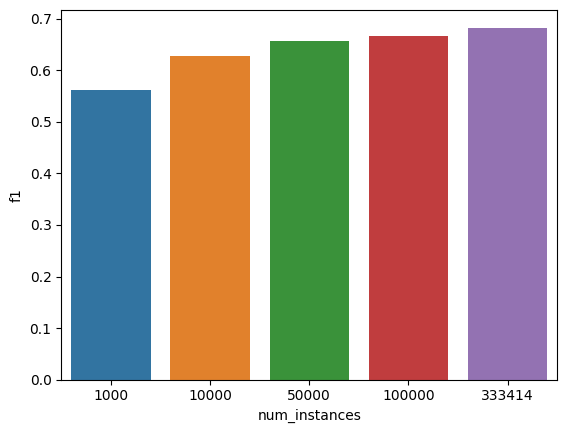

In [23]:
print(performace_f1_scores)

df = pd.DataFrame({'num_instances': training_sizes, 'f1': performace_f1_scores})
sns.barplot(data=df, x='num_instances', y='f1')

Try a uni, bi, and trigram vectorizer

In [27]:
trigram_vectorizer = TfidfVectorizer(stop_words='english', min_df=25, ngram_range=(1,3))
X_train = trigram_vectorizer.fit_transform(train_df.original_text)
print(X_train.shape)
clf = LogisticRegression(random_state=RANDOM_SEED, multi_class='ovr', solver= 'newton-cholesky')
clf.fit(X_train, y_train)
#featurize the dev data
X_dev = trigram_vectorizer.transform(dev_df.original_text)
#predict the dev data and score
lr_trigram_dev_preds = clf.predict(X_dev)
lr_f1 = f1_score(y_dev, lr_trigram_dev_preds, average='macro')

(333414, 23797)


In [28]:
print(lr_f1)

0.6880169450552442


min_df @ 500, ngram_range(1,3), multi_class='ovr', solver = 'newton-cholesky' (didn't take too long) scored 0.6451618658
min_df @  25, ngram_range(1,3), multi_class='ovr', solver = 'newton-cholesky' (6m 19.1s) scored 0.6880169450552442

Read in the Dale Chall text - into a list

In [31]:
dc_text = open(r'/Users/staceybruestle/Documents/Documents/Education/MADS/Coursework/aSIADS696- Milestone 2/Readability Project/Data/dale_chall.txt', "r")
dalechall_file = dc_text.read()
# split text on new line
dalechall_list = dalechall_file.split('\n')
print(dalechall_list[0:5])

['a', 'able', 'aboard', 'about', 'above ']


In [32]:
len(dalechall_list)

2950